In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
import random
import time
import os 
import json
from tqdm import tqdm
# from thefuzz import fuzz, process
import powerlaw

import sqlite3

# !pip install mpmath 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('float_format', '{:f}'.format)

def plot_degree(degree, number_of_bins=50, log_binning=True, base=2):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    degree (np.ndarray or list):
        a vector of length N that corresponds to the degree, k_i, of every
        node, v_i, in the network

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool)
        if you are plotting on a log-log axis, then this is useful
    
    base (int):
        log base, defaults to 2
        
    Returns
    -------
    x, y (np.ndarray):
        the support and probability values of the degree distribution
    
    """
    
    # We need to define the support of our distribution
    lower_bound = min(degree)
    upper_bound = max(degree)
    
    # And the bins
    if log_binning:
        log = np.log2 if base == 2 else np.log10
        lower_bound = log(lower_bound) if lower_bound >= 1 else 0.0
        upper_bound = log(upper_bound)
        bins = np.logspace(lower_bound,upper_bound,number_of_bins, base = base)
    else:
        bins = np.linspace(lower_bound,upper_bound,number_of_bins)
    
    # Then we can compute the histogram using numpy
    y, __ = np.histogram(degree, 
                         bins=bins,
                         density=True)
    # Now, we need to compute for each y the value of x
    x = bins[1:] - np.diff(bins)/2.0
        
    return x, y

# sql loading

In [3]:
# ### CID FROM CSV    (~10 secs)
# unique_cid_all = contributor_data['bonica.cid'].unique()
# # print(unique_cid_all)
# unique_cid_all = unique_cid_all[~np.isnan(unique_cid_all)]
# # print(unique_cid_all)

### CID FROM sql    (~40 secs)
sqliteConnection = sqlite3.connect('dime_v3.sqlite3')
cursor = sqliteConnection.cursor()
unique_cid_all_sql = cursor.execute("SELECT DISTINCT bonica_cid FROM donorDB").fetchall()
unique_cid_all_sql = [x[0] for x in unique_cid_all_sql]
sql_cid_series = pd.Series(unique_cid_all_sql)
sql_cid_series = sql_cid_series[~pd.isnull(sql_cid_series)]
unique_cid_all_sql_array = sql_cid_series.to_numpy()

### RID FROM CSV    (~1 secs)
unique_rid_all = recipient_data['bonica.rid'].unique()

# Load year database

In [27]:
## CYCLE TO READ
del contrib_12
cycle = '2012'
# columns_to_read_sql = ['amount', 'bonica_cid', 'contributor_name', 'contributor_type', 'contributor_gender',  'contributor_state', 'contributor_occupation',  'occ_standardized', 'is_corp', 'recipient_name', 'bonica_rid', 'recipient_party', 'recipient_type', 'recipient_state', 'seat', 'contributor_cfscore', 'candidate_cfscore', 'bk_ref_transaction_id']
columns_to_read_csv = ['cycle', 'date', 'transaction.id', 'amount', 'bonica.cid', 'contributor.name', 'contributor.type', 'contributor.gender',  'contributor.state', 'contributor.occupation',  'occ.standardized', 'is.corp', 'recipient.name', 'bonica.rid', 'recipient.party', 'recipient.type', 'recipient.state', 'seat', 'contributor.cfscore', 'candidate.cfscore', 'bk.ref.transaction.id']
contrib_file_to_read = "contribDB_" + cycle + ".csv"

contrib_12 = pd.read_csv(contrib_file_to_read, usecols=columns_to_read_csv, encoding="latin1")
# contrib_00 = pd.read_csv(contrib_file_to_read, usecols=columns_to_read_csv, encoding="latin1")

# run time for 2000: ~25 secs
# run time for 2008: ~3 mins
# run time for 2012: ~3 mins

C:\Users\User\AppData\Local\Temp\ipykernel_14772\1268811709.py:8: DtypeWarning: Columns (14,19,21,22,25,27,40) have mixed types. Specify dtype option on import or set low_memory=False.
  contrib_12 = pd.read_csv(contrib_file_to_read, usecols=columns_to_read_csv, encoding="latin1")


## node Id mapping

In [28]:
recipient_data = pd.read_csv("dime_recipients_1979_2020.csv")
rid_to_cid_dict = recipient_data[recipient_data['bonica.cid'] >= 0].groupby('bonica.rid')['bonica.cid'].agg(lambda x: list(set(x))).to_dict()
# ~4 secs

# contributor_data = pd.read_csv("dime_contributors_1979_2020.csv", encoding="latin1")
# approx 7 min load time

C:\Users\User\AppData\Local\Temp\ipykernel_14772\3023162193.py:1: DtypeWarning: Columns (12,15,16,17,40,42,43,44,46,48,49,53,54,57,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  recipient_data = pd.read_csv("dime_recipients_1979_2020.csv")


In [29]:
contrib_df = contrib_12
contrib_df_house_comm = contrib_df[contrib_df['seat'].isin(['federal:committee', 'federal:527', 'federal:president', 'federal:senate'])]
contrib_for_net = contrib_df_house_comm

# contrib_for_net = contrib_00_fed
unique_rid = contrib_for_net['bonica.rid'].unique()
unique_cid = contrib_for_net['bonica.cid'].unique()

# unique_rid = unique_rid_all
# unique_cid = unique_cid_all_sql_array

n_rid = len(unique_rid)
n_cid = len(unique_cid)

b_rid_to_nid = dict(zip(unique_rid, range(1, n_rid+1)))

b_cid_to_nid = dict(zip(unique_cid, range(n_rid+1, n_rid+n_cid+1)))

count_replace = 0
for key in b_rid_to_nid:
    if rid_to_cid_dict.get(key, False):
        for cid in rid_to_cid_dict[key]:
            if cid in b_cid_to_nid:
                count_replace += 1
                # print(b_cid_to_nid.get(cid, 'Nan'))
                # print(str(key) + ' - ' + str(b_rid_to_nid[key]) + ' : ' + str(b_cid_to_nid.get(cid, 'Nan')) + ' - ' + str(cid))
                b_cid_to_nid[cid] = b_rid_to_nid[key]
                # print(str(key) + ' - ' + str(b_rid_to_nid[key]) + ' : ' + str(b_cid_to_nid[cid]) + ' - ' + str(cid))
                # print(str(key) + ' : ' + str(cid))
print(count_replace)
# run time: ~7 secs

## apply Node IDs

# print(contrib_for_net.shape)
contrib_for_net.loc[:, ('source_id')] = contrib_for_net['bonica.cid'].map(b_cid_to_nid) #.fillna('')
# print(contrib_for_net.shape)
contrib_for_net.loc[:, ('sink_id')] = contrib_for_net['bonica.rid'].map(b_rid_to_nid) #.fillna('')
# print(contrib_for_net.shape)
# display(contrib_for_net)
# ~20 secs

aggregated_amounts = contrib_for_net.groupby(['source_id', 'sink_id']).agg({'amount': 'sum', 
                                                                            'cycle': 'first', 'date': 'first', 'transaction.id': 'first', 'bonica.cid': 'first', 'contributor.name': 'first', 'contributor.type': 'first',
                                                                            'contributor.gender': 'first', 'contributor.state': 'first', 'contributor.occupation': 'first', 'occ.standardized': 'first', 'is.corp': 'first',
                                                                            'recipient.name': 'first', 'bonica.rid': 'first', 'recipient.party': 'first', 'recipient.type': 'first', 'recipient.state': 'first',
                                                                            'seat': 'first', 'contributor.cfscore': 'first', 'candidate.cfscore': 'first', 'bk.ref.transaction.id': 'first'}).reset_index()

summed_contribs_for_net = aggregated_amounts
# display(aggregated_amounts)

1010


C:\Users\User\AppData\Local\Temp\ipykernel_14772\3752065177.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contrib_for_net.loc[:, ('source_id')] = contrib_for_net['bonica.cid'].map(b_cid_to_nid) #.fillna('')
C:\Users\User\AppData\Local\Temp\ipykernel_14772\3752065177.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contrib_for_net.loc[:, ('sink_id')] = contrib_for_net['bonica.rid'].map(b_rid_to_nid) #.fillna('')


### samples of data for presentation

In [30]:

display(summed_contribs_for_net.iloc[13])
summed_contribs_for_net[summed_contribs_for_net['sink_id'].isna()]

source_id                                        12
sink_id                                          15
amount                                  2500.000000
cycle                                          2012
date                                     2012-09-27
transaction.id            indv::2012:13012300032758
bonica.cid                  5000005664020698.000000
contributor.name                  feinstein, dianne
contributor.type                                  I
contributor.gender                                F
contributor.state                                CA
contributor.occupation                      senator
occ.standardized                          politicos
is.corp                                        None
recipient.name               DONNELLY, JOSEPH SIMON
bonica.rid                                  cand982
recipient.party                                 100
recipient.type                                 CAND
recipient.state                                  IN
seat        

,source_id,sink_id,amount,cycle,date,transaction.id,bonica.cid,contributor.name,contributor.type,contributor.gender,contributor.state,contributor.occupation,occ.standardized,is.corp,recipient.name,bonica.rid,recipient.party,recipient.type,recipient.state,seat,contributor.cfscore,candidate.cfscore,bk.ref.transaction.id


In [ ]:
# print(summed_contribs_for_net.shape)

# display(contrib_df_house_comm[contrib_df_house_comm['name'] == 3545311])

display(contrib_df_house_comm.iloc[13, :])

display(contrib_df_house_comm.head(25))
# rid_to_cid_dict = 
contrib_df_house_comm.iloc[13]
contrib_for_net[contrib_for_net['sink_id'].isna()]



## testing data processing and data cleaning

In [ ]:
# contrib_df = contrib_12
# del contrib_08

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [80]:
# display(contrib_df)
# display(contrib_df.iloc[:,[14]])
# counts = pd.DataFrame(contrib_df['transaction.id'].value_counts())
# print(counts[counts.iloc[:,0] <= 1])

# contrib_df['transaction.id' == '105694355']


In [79]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# display(contrib_df)

# display(contrib_80_fed[(contrib_80_fed['seat'] == 'federal:president') & (contrib_80_fed['recipient_type'] == 'comm')])
filtered_db = contrib_df[(~contrib_df['bk.ref.transaction.id'].isna())]

print(contrib_df['bk.ref.transaction.id'].value_counts())
# print(filtered_db['contributor_type'].value_counts())
display(filtered_db)

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 50)
# display(contrib_for_net)
# # display(contrib_for_net.drop('amount',axis = 1))

# summed_amounts = contrib_for_net.groupby(['source_id', 'sink_id'], as_index=False)['amount'].sum().reset_index()
# display(summed_amounts)

# left_merged_nodrop = pd.merge(summed_amounts, contrib_for_net, how="left", on=["source_id", "sink_id"])
# display(left_merged_nodrop)

# left_merged = pd.merge(summed_amounts, contrib_for_net.drop('amount',axis = 1), how="left", on=["source_id", "sink_id"])
# # display(left_merged)
# summed_contribs_for_net = left_merged   #[summed_amounts['amount'] > min_link_amount]
# display(summed_contribs_for_net)

In [ ]:
# columns_to_read_csv = ['cycle', 'date', 'transaction.id', 'amount', 
#                        'bonica.cid', 'contributor.name', 'contributor.type', 'contributor.gender',  'contributor.state', 'contributor.occupation',  'occ.standardized', 'is.corp', 
#                        'recipient.name', 'bonica.rid', 'recipient.party', 'recipient.type', 'recipient.state', 'seat', 
#                        'contributor.cfscore', 'candidate.cfscore', 'bk.ref.transaction.id']



# agg_amounts = contrib_for_net.groupby(['source_id', 'sink_id'])['amount'].transform("sum")
# display(agg_amounts)

# aggregated_amounts = contrib_for_net.groupby(['source_id', 'sink_id']).agg(total_amount=pd.NamedAgg(column="amount", aggfunc="sum"))
    # b_min=pd.NamedAgg(column="B", aggfunc="min"),



# Networkx

In [32]:
# columns_to_read_csv = ['transaction.id', 'amount', 
#                        'bonica.cid', 'contributor.name', 'contributor.type', 'contributor.gender',  'contributor.state', 'contributor.occupation',  'occ.standardized', 'is.corp', 
#                        'recipient.name', 'bonica.rid', 'recipient.party', 'recipient.type', 'recipient.state', 'seat', 
#                        'contributor.cfscore', 'candidate.cfscore', 'bk.ref.transaction.id']

# summed_contribs_for_net = aggregated_amounts
# display(aggregated_amounts)

contrib_net = nx.DiGraph()

for index, row in summed_contribs_for_net.iterrows():
# if (not contrib_net.has_node(row['source_id'])):
    contrib_net.add_node(row['source_id'],
                        name_contributor=row['contributor.name'],
                        corp_ind=row['contributor.type'],
                        gender_contributor=row['contributor.gender'],
                        state_contributor=row['contributor.state'],
                        occupation_standardized=row['occ.standardized'],
                        occupation_writen=row['contributor.occupation'],
                        partisan_contributor=row['contributor.cfscore'])
# if (not contrib_net.has_node(row['sink_id'])):
    contrib_net.add_node(row['sink_id'],
                        name_recipient=row['recipient.name'],
                        cand_comm=row['recipient.type'],
                        party_recipient=row['recipient.party'],
                        state_recipient=row['contributor.state'],
                        partisan_recipient=row['candidate.cfscore'],
                        seat=row['seat'])
    contrib_net.add_edge(row['source_id'], row['sink_id'], weight=row['amount'])

# 2000 run time: ~1 min
# 2008 run time: ~2.5 min
# 2012 run time: ~4.5 min

In [35]:
nx.write_gml(contrib_net, "2012_pres_sen_v1.gml", str)
#2008: ~ 1 min
#2012: ~ 2 min 
# del contrib_net

In [34]:
print(contrib_net)
print("Graph density:\t %1.9f" % nx.density(contrib_net))
# contrib_net.nodes(data=True)    2034 in 2008 has both in and out
contrib_net.nodes[26] #('1123', data=True)

DiGraph with 3054372 nodes and 5418592 edges
Graph density:	 0.000000581


{'name_contributor': 'coons, christopher',
 'corp_ind': 'I',
 'gender_contributor': 'M',
 'state_contributor': 'DE',
 'occupation_standardized': 'politicos',
 'occupation_writen': 'legislator',
 'partisan_contributor': -0.71,
 'name_recipient': 'COONS, CHRISTOPHER A',
 'cand_comm': 'CAND',
 'party_recipient': '100',
 'state_recipient': 'MD',
 'partisan_recipient': -0.71,
 'seat': 'federal:senate'}

### unweighted degree

In [11]:
print(contrib_net)

# list(contrib_net.nodes(data=True))[:10]

degree = contrib_net.degree()
in_degree = contrib_net.in_degree()
out_degree = contrib_net.out_degree()

# I ususally make this a dictionary straight away
degree = dict(degree)
in_degree = dict(in_degree)
out_degree = dict(out_degree)

# print(degree)

node = list(contrib_net.nodes())[1]

print('Degree of node %s: %d' % (node, degree[node]))
print('In-degree of node %s: %d' % (node, in_degree[node]))
print('Out-degree of node %s: %d' % (node, out_degree[node]))
# print("Node %s's political orientation: %s" %(node, contrib_net.nodes[node]['political_orientation']))
print()
print("Network-level properties")
print("Average degree: %1.2f" % np.mean(list(degree.values())))
print("Average in-degree: %1.3f" % np.mean(list(in_degree.values())))
print("Average out-degree: %1.3f" % np.mean(list(out_degree.values())))

print("Graph density:\t %1.7f" % nx.density(contrib_net))
# print(contrib_net.nodes(data=True))
# print(contrib_net.edges(data=True))

# nx.write_gml(contrib_net, "2000_fed_50000amount_no_label.gml", str)

DiGraph with 2417413 nodes and 3417291 edges
Degree of node 37: 174283
In-degree of node 37: 174281
Out-degree of node 37: 2

Network-level properties
Average degree: 2.83
Average in-degree: 1.414
Average out-degree: 1.414
Graph density:	 0.0000006


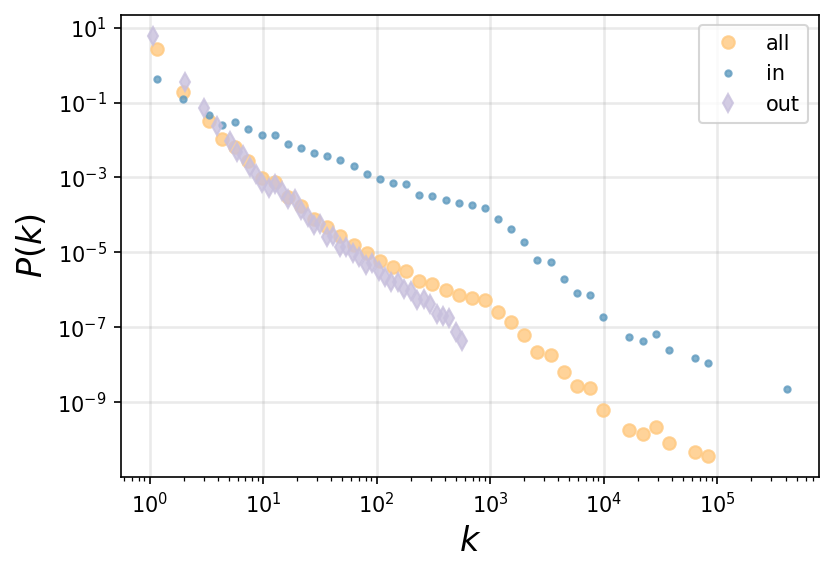

In [40]:
degree_list = list(degree.values())
in_degree_list = list(in_degree.values())
out_degree_list = list(out_degree.values())

x_all_degree, y_all_degree = plot_degree(degree_list, number_of_bins=50, log_binning=True, base=2)
x_in_degree, y_in_degree = plot_degree(in_degree_list, number_of_bins=50, log_binning=True, base=2)
x_out_degree, y_out_degree = plot_degree(out_degree_list, number_of_bins=50, log_binning=True, base=2)

cols = ['#008795','#629CC0','#C8C0DD','#DEA8AB','#FFC980','#E3EA7A','#76C1CA','#999999']

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x_all_degree, y_all_degree,'o', color=cols[4], label='all', alpha=0.8)
ax.loglog(x_in_degree, y_in_degree,'.', color=cols[1], label='in', alpha=0.8)
ax.loglog(x_out_degree, y_out_degree,'d', color=cols[2], label='out', alpha=0.8)

ax.set_xlabel(r"$k$", fontsize=16)
ax.set_ylabel(r"$P(k)$", fontsize=16)

ax.legend(fontsize=10)

ax.grid(linewidth=1.25, color='#999999', alpha=0.2, linestyle='-')

# plt.savefig('../figs/pngs/PolBlogs_inout_degreedist.png', dpi=425, bbox_inches='tight')
# plt.savefig('../figs/pdfs/PolBlogs_inout_degreedist.pdf', bbox_inches='tight')
plt.show()

In [41]:
all_degree_fit = powerlaw.Fit(degree_list)
print(all_degree_fit.power_law.alpha)
in_degree_fit = powerlaw.Fit(in_degree_list)
print(in_degree_fit.power_law.alpha)
out_degree_fit = powerlaw.Fit(out_degree_list)
print(out_degree_fit.power_law.alpha)

Calculating best minimal value for power law fit
2.584418816701878%
Calculating best minimal value for power law fit
2.5811192811445727


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
2.605354273535514%


### weighted degree

In [42]:
print(contrib_net)

# list(contrib_net.nodes(data=True))[:10]

degree_weighted = contrib_net.degree(weight='weight')
in_degree_weighted = contrib_net.in_degree(weight='weight')
out_degree_weighted = contrib_net.out_degree(weight='weight')

# I ususally make this a dictionary straight away
degree_weighted = dict(degree_weighted)
in_degree_weighted = dict(in_degree_weighted)
out_degree_weighted = dict(out_degree_weighted)

# print(degree)

node = list(contrib_net.nodes())[1]

print('Degree of node %s: %d' % (node, degree_weighted[node]))
print('In-degree of node %s: %d' % (node, in_degree_weighted[node]))
print('Out-degree of node %s: %d' % (node, out_degree_weighted[node]))
# print("Node %s's political orientation: %s" %(node, contrib_net.nodes[node]['political_orientation']))
print()
print("Network-level properties")
print("Average degree: %1.2f" % np.mean(list(degree_weighted.values())))
print("Average in-degree: %1.3f" % np.mean(list(in_degree_weighted.values())))
print("Average out-degree: %1.3f" % np.mean(list(out_degree_weighted.values())))

print("Graph density:\t %1.7f" % nx.density(contrib_net))
# print(contrib_net.nodes(data=True))
# print(contrib_net.edges(data=True))

# nx.write_gml(contrib_net, "2000_fed_50000amount_no_label.gml", str)

DiGraph with 1211360 nodes and 1766094 edges
Degree of node 1445.0: 1647214
In-degree of node 1445.0: 1647144
Out-degree of node 1445.0: 70

Network-level properties
Average degree: 5713.98
Average in-degree: 2856.989
Average out-degree: 2856.989
Graph density:	 0.0000012


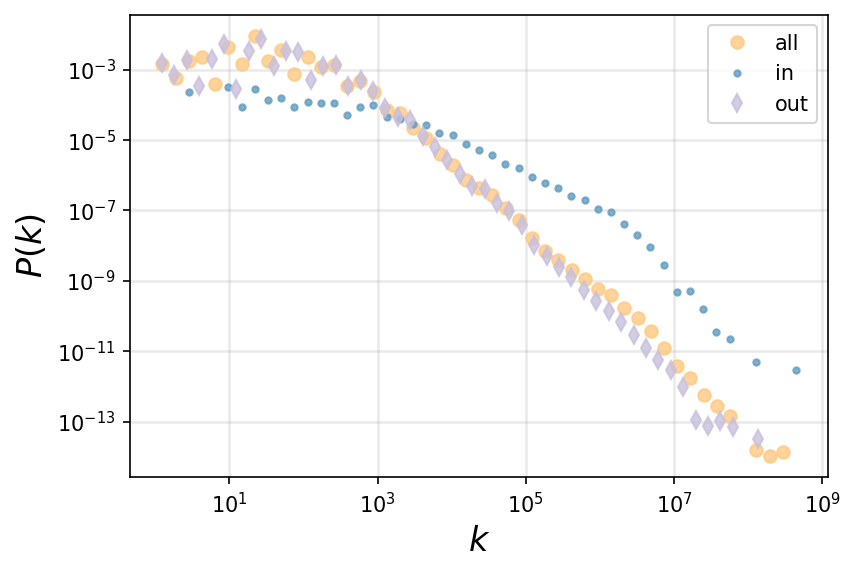

In [43]:
degree_list_weighted = list(degree_weighted.values())
in_degree_list_weighted = list(in_degree_weighted.values())
out_degree_list_weighted = list(out_degree_weighted.values())

x_all_degree, y_all_degree = plot_degree(degree_list_weighted, number_of_bins=50, log_binning=True, base=2)
x_in_degree, y_in_degree = plot_degree(in_degree_list_weighted, number_of_bins=50, log_binning=True, base=2)
x_out_degree, y_out_degree = plot_degree(out_degree_list_weighted, number_of_bins=50, log_binning=True, base=2)

cols = ['#008795','#629CC0','#C8C0DD','#DEA8AB','#FFC980','#E3EA7A','#76C1CA','#999999']

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x_all_degree, y_all_degree,'o', color=cols[4], label='all', alpha=0.8)
ax.loglog(x_in_degree, y_in_degree,'.', color=cols[1], label='in', alpha=0.8)
ax.loglog(x_out_degree, y_out_degree,'d', color=cols[2], label='out', alpha=0.8)

ax.set_xlabel(r"$k$", fontsize=16)
ax.set_ylabel(r"$P(k)$", fontsize=16)

ax.legend(fontsize=10)

ax.grid(linewidth=1.25, color='#999999', alpha=0.2, linestyle='-')

# plt.savefig('../figs/pngs/PolBlogs_inout_degreedist.png', dpi=425, bbox_inches='tight')
# plt.savefig('../figs/pdfs/PolBlogs_inout_degreedist.pdf', bbox_inches='tight')
plt.show()

In [53]:
display(degree_list)
degree_list_weighted_int = [int(x) for x in degree_list_weighted]

[1,
 1282,
 407,
 1623,
 7,
 532,
 316,
 1306,
 716,
 508,
 2912,
 129,
 1,
 708,
 7,
 1269,
 3086,
 1267,
 913,
 167,
 61,
 524,
 2,
 2026,
 123,
 19,
 7204,
 827,
 892,
 2039,
 2564,
 832,
 949,
 175,
 630,
 550,
 1114,
 33172,
 86850,
 141,
 146,
 207,
 121,
 2762,
 252,
 400,
 3,
 795,
 1516,
 1774,
 1,
 856,
 4,
 440,
 288,
 516,
 1,
 929,
 4,
 1459,
 1315,
 772,
 754,
 4,
 608,
 923,
 737,
 466572,
 4,
 959,
 25,
 575,
 755,
 599,
 624,
 393,
 1354,
 1673,
 2053,
 1119,
 701,
 8142,
 6815,
 104,
 2862,
 1098,
 525,
 1338,
 142,
 81,
 44,
 7,
 315,
 578,
 1364,
 632,
 282,
 3,
 585,
 3707,
 965,
 685,
 376,
 587,
 919,
 919,
 2178,
 245,
 600,
 511,
 635,
 1326,
 4006,
 1736,
 5284,
 4889,
 3896,
 1253,
 100,
 1074,
 1,
 32,
 9,
 1197,
 1333,
 9134,
 33,
 154,
 2,
 290,
 1319,
 1,
 1,
 9,
 8,
 442,
 966,
 2677,
 1904,
 18,
 1991,
 643,
 1413,
 1397,
 748,
 1559,
 1165,
 966,
 168,
 642,
 172,
 197,
 571,
 214,
 430,
 1,
 924,
 6,
 393,
 1494,
 518,
 47,
 2,
 358,
 1,
 601,
 1,
 83

In [56]:
all_degree_fit_weighted = powerlaw.Fit([int(x) for x in degree_list_weighted])
print(all_degree_fit_weighted.power_law.alpha)
in_degree_fit_weighted = powerlaw.Fit([int(x) for x in in_degree_list_weighted])
print(in_degree_fit_weighted.power_law.alpha)
out_degree_fit_weighted = powerlaw.Fit([int(x) for x in out_degree_list_weighted])
print(out_degree_fit_weighted.power_law.alpha)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
2.122726885426685%


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
2.463307775038481%


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
1.996232220780499%


# from SHubham

In [74]:
import gc
from tqdm import tqdm

def get_rid_and_cid_mapping(df):
  cid_mapping = pd.DataFrame({'contributor_ids':[], 'new_id':[]})
  rid_to_cid_dict = get_cid_to_rid_mapping()
  recipient_ids = df['bonica.rid'].unique()
  rid_mapping = pd.DataFrame({'recipient_ids': recipient_ids, 'new_id': range(1, len(recipient_ids) + 1)})
  for key, value in tqdm(rid_to_cid_dict.items()):
    for i in range(len(value)):
        # print(key,value[i])
        if key in rid_mapping['recipient_ids'].values:
            # print(key,value[i])
            cid_mapping = pd.concat([cid_mapping,pd.DataFrame({'contributor_ids':[value[i]], 'new_id':[rid_mapping[rid_mapping.recipient_ids==key]['new_id'].values[0]]})])

  contributor_ids = df['bonica.cid'].unique()
  contributor_ids = [x for x in contributor_ids if x not in cid_mapping['contributor_ids'].values]
  cid_mapping_rem = pd.DataFrame({'contributor_ids': contributor_ids, 'new_id': range(rid_mapping.iloc[-1]['new_id']+1, rid_mapping.iloc[-1]['new_id']+1 + len(contributor_ids))})
  cid_mapping = pd.concat([cid_mapping,cid_mapping_rem])
  cid_mapping.reset_index(drop=True, inplace=True)
  return cid_mapping,rid_mapping

def get_cid_to_rid_mapping():
  recipient_data = pd.read_csv("dime_recipients_1979_2020.csv") #pd.read_csv("G:\My Drive\network science course\NETS Project DIME\Data and Code\dime_recipients_1979_2020.csv")
  rid_to_cid_dict = recipient_data[(recipient_data['bonica.cid'] >= 0)].groupby('bonica.rid')['bonica.cid'].agg(lambda x: list(set(x))).to_dict()
  del recipient_data
  gc.collect()
  return rid_to_cid_dict


def get_network(df):

  cid_mapping,rid_mapping = get_rid_and_cid_mapping(df)

  result_df = df.merge(cid_mapping, left_on='bonica.cid', right_on='contributor_ids', how='left')
  del df
  gc.collect()
  result_df.rename(columns={'new_id': 'Contributor_ID'}, inplace=True)
  result_df = result_df.merge(rid_mapping, left_on='bonica.rid', right_on='recipient_ids', how='left')
  result_df.rename(columns={'new_id': 'Recipient_ID'}, inplace=True)
  # result_df.drop(['contributor_ids', 'recipient_ids'], axis=1, inplace=True)
  result_df = result_df[['Contributor_ID','contributor_ids','contributor.name','Recipient_ID','recipient.name','contributor.type','recipient.type','contributor.cfscore','candidate.cfscore','amount']]
  result_df = result_df.groupby(['Contributor_ID','Recipient_ID']).agg({'amount':'sum','contributor.name':'first','recipient.name':'first','recipient.type':'first','contributor.type':'first', 'contributor_ids':'first'}).reset_index()  #,'contributor.cfscore','candidate.cfscore'
  print(result_df['Contributor_ID'].unique().shape, result_df['Recipient_ID'].unique().shape)
  return result_df


In [95]:
cid_mapping, rid_mapping = get_rid_and_cid_mapping(contrib_08[contrib_df['seat'].isin(['federal:committee', 'federal:527', 'federal:house'])])

C:\Users\User\AppData\Local\Temp\ipykernel_26568\100941436.py:24: DtypeWarning: Columns (12,15,16,17,40,42,43,44,46,48,49,53,54,57,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  recipient_data = pd.read_csv("dime_recipients_1979_2020.csv") #pd.read_csv("G:\My Drive\network science course\NETS Project DIME\Data and Code\dime_recipients_1979_2020.csv")
100%|██████████| 85370/85370 [00:10<00:00, 8535.97it/s] 


In [75]:
result_df_2008 = get_network(contrib_08[contrib_df['seat'].isin(['federal:committee', 'federal:527', 'federal:house'])])

C:\Users\User\AppData\Local\Temp\ipykernel_26568\100941436.py:24: DtypeWarning: Columns (12,15,16,17,40,42,43,44,46,48,49,53,54,57,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  recipient_data = pd.read_csv("dime_recipients_1979_2020.csv") #pd.read_csv("G:\My Drive\network science course\NETS Project DIME\Data and Code\dime_recipients_1979_2020.csv")
100%|██████████| 85370/85370 [00:10<00:00, 8468.31it/s] 


(1769701,) (7505,)


In [76]:
search_db = contrib_08[contrib_df['seat'].isin(['federal:committee', 'federal:527', 'federal:house'])]
# display(search_db[search_db['bonica.cid'] == 3300163630])
# print(cid_mapping[cid_mapping.contributor_ids == 3300163630])

display(result_df_2008[result_df_2008.Contributor_ID == 1178402])

,Contributor_ID,Recipient_ID,amount,contributor.name,recipient.name,recipient.type,contributor.type,contributor_ids
1914470,1178402.000000,2773,225.000000,"peart, dennis",CHRYSLER SERVICE CONTRACTS INC. POLITICAL SUPP...,COMM,I,3300163630.000000


In [59]:
result_df_2008[result_df_2008.duplicated(subset=['Contributor_ID','Recipient_ID'])]

summed_contribs_for_net[summed_contribs_for_net.duplicated(subset=['source_id','sink_id'])]

,source_id,sink_id,amount,cycle,date,transaction.id,bonica.cid,contributor.name,contributor.type,contributor.gender,...,is.corp,recipient.name,bonica.rid,recipient.party,recipient.type,recipient.state,seat,contributor.cfscore,candidate.cfscore,bk.ref.transaction.id


In [82]:
print(len(result_df_2008.Contributor_ID.unique()))
print(len(result_df_2008.Recipient_ID.unique()))
print(len(summed_contribs_for_net.source_id.unique()))
print(len(summed_contribs_for_net.sink_id.unique()))

1769701
7505
1769695
7505


In [98]:
pd.set_option('float_format', '{:f}'.format)

# print(set(result_df_2008['contributor.name']) - set(summed_contribs_for_net['contributor.name']))# peart, dennis
print(len(set(result_df_2008['contributor_ids']))) #set(summed_contribs_for_net['bonica.cid'])# peart, dennis

# result_df_2008.loc['contributor_ids', 'Contributor_ID'].unique()

cid_mapping.value_counts()

# cid_counts = pd.DataFrame(result_df_2008.groupby('contributor_ids').agg({'Contributor_ID':'count'}))
# cid_counts
# set([1,2,3,4]) - set([3,4,5,6])
# print(set(result_df_2008['contributor.name']))
# print(set(summed_contribs_for_net['contributor.name']))

# print(set(result_df_2008['contributor.name']) - set(summed_contribs_for_net['contributor.name']))# peart, dennis


# display(summed_contribs_for_net[summed_contribs_for_net['contributor.name'] == 'peart, dennis'])
# display(result_df_2008[result_df_2008['contributor.name'] == 'peart, dennis'])


1769695


contributor_ids          new_id        
66.000000                9078.000000       1
29185960003.000000       72780.000000      1
29185960723.000000       569379.000000     1
29185960667.000000       609287.000000     1
29185960651.000000       1766596.000000    1
                                          ..
3379172743.000000        1482887.000000    1
3379172713.000000        544007.000000     1
3379172710.000000        1731244.000000    1
3379172676.000000        1117159.000000    1
5000037659964898.000000  1661286.000000    1
Name: count, Length: 1771433, dtype: int64

In [48]:
# print(result_df_2008.shape)
print(contrib_for_net.shape)
print(summed_contribs_for_net.shape)

# display(result_df_2008[result_df_2008['Recipient_ID'].isna() | result_df_2008['Contributor_ID'].isna()].shape)
display(contrib_for_net[contrib_for_net['source_id'].isna() | contrib_for_net['sink_id'].isna()].shape)
display(summed_contribs_for_net[summed_contribs_for_net['source_id'].isna() | summed_contribs_for_net['sink_id'].isna()].shape)

# display(result_df_2008[result_df_2008['Recipient_ID'].isna() | result_df_2008['Contributor_ID'].isna()])
display(contrib_for_net[contrib_for_net['source_id'].isna() | contrib_for_net['sink_id'].isna()])
display(summed_contribs_for_net[summed_contribs_for_net['source_id'].isna() | summed_contribs_for_net['sink_id'].isna()])

(15912074, 23)
(4826803, 23)


(0, 23)

(0, 23)

,cycle,transaction.id,amount,date,bonica.cid,contributor.name,contributor.type,contributor.gender,contributor.state,contributor.occupation,occ.standardized,is.corp,recipient.name,bonica.rid,recipient.party,recipient.type,recipient.state,seat,bk.ref.transaction.id,contributor.cfscore,candidate.cfscore,source_id,sink_id


,source_id,sink_id,amount,cycle,date,transaction.id,bonica.cid,contributor.name,contributor.type,contributor.gender,contributor.state,contributor.occupation,occ.standardized,is.corp,recipient.name,bonica.rid,recipient.party,recipient.type,recipient.state,seat,contributor.cfscore,candidate.cfscore,bk.ref.transaction.id
